### 统计生命周期信息
绘制生命周期时间线图、内存访问图（以时间为X轴，内存地址空间为Y轴），统计运行总时间，计算实际活跃率

#### 1. 数据预处理

##### 1.1 读取数据

In [93]:
results_dir = "results"
page_size_byte = 4096

In [94]:
import pandas as pd
from sqlalchemy import create_engine

# 使用SQLAlchemy连接
engine = create_engine('sqlite:///data/xor/0_test_2.sqlite3')  # 注意路径格式：sqlite:///
df = pd.read_sql_table('trace', engine)
print(df.columns)
print(df.head())

Index(['ID', 'ParentID', 'Kind', 'What', 'Location', 'StartTime', 'EndTime',
       'DeviceID', 'PID', 'Address', 'ByteSize'],
      dtype='object')
                     ID       ParentID     Kind              What  \
0             1_req_out       1@Driver  req_out  *mem.AllocateReq   
1             2_req_out       2@Driver  req_out  *mem.AllocateReq   
2             3_req_out       3@Driver  req_out  *mem.AllocateReq   
3             4_req_out       4@Driver  req_out  *mem.AllocateReq   
4  14831@GPU[1].DRAM[0]  14831_req_out   req_in     *mem.WriteReq   

         Location  StartTime   EndTime  DeviceID  PID     Address  ByteSize  
0          Driver   0.000000  0.000000         1    1  4294971392        48  
1          Driver   0.000000  0.000000         1    1  4294975488        48  
2          Driver   0.000000  0.000000         1    1  4294979584        40  
3          Driver   0.000000  0.000000         1    1  4294983680        40  
4  GPU[1].DRAM[0]   0.000015  0.000015        

In [95]:
# 向量化计算页范围
df['StartPage'] = df['Address'] // 4096
df['EndPage'] = (df['Address'] + df['ByteSize'] - 1) // 4096

# 筛选出内存相关的请求
mem_df = df[ df['What'].isin(['*mem.AllocateReq', '*mem.FreeReq']) | 
                df['What'].isin(['*mem.ReadReq', '*mem.WriteReq']) & 
                    ((df['Location'].str.contains('DRAM', na=False)) 
                    #  | (df['Location'].str.contains('L1', na=False)) 
                    #  | (df['Location'].str.contains('L2', na=False)) 
                    #  | (df['Location'].str.contains('DMA', na=False)) 
                    #  | (df['Kind'].str.contains('req_out') & (df['Location'].str.contains('AddrTrans', na=False)))
                    )
            ]

# print(mem_df[mem_df['What'].isin(['*mem.FreeReq'])])

# 生成所有页的访问记录
rows = []
for _, row in mem_df.iterrows():
    for page in range(row['StartPage'], row['EndPage'] + 1):
        rows.append({
            'DeviceID': row['DeviceID'],
            # 'PID': row['PID'],
            'PageID': page,
            'AccessType': row['What'],
            'StartTime': row['StartTime'],
            'EndTime': row['EndTime'],
        })

page_access_df = pd.DataFrame(rows)
print(page_access_df)
# print(page_access_df[page_access_df['AccessType'].isin(['*mem.FreeReq'])])


      DeviceID   PageID        AccessType  StartTime   EndTime
0            1  1048577  *mem.AllocateReq   0.000000  0.000000
1            1  1048578  *mem.AllocateReq   0.000000  0.000000
2            1  1048579  *mem.AllocateReq   0.000000  0.000000
3            1  1048580  *mem.AllocateReq   0.000000  0.000000
4            0  1048577     *mem.WriteReq   0.000015  0.000015
...        ...      ...               ...        ...       ...
1367         0  1048744     *mem.WriteReq   0.003280  0.003280
1368         0  1048752     *mem.WriteReq   0.003280  0.003280
1369         0  1048744      *mem.ReadReq   0.003288  0.003288
1370         0  1048752      *mem.ReadReq   0.003298  0.003298
1371         0  1048579      *mem.ReadReq   0.003307  0.003307

[1372 rows x 5 columns]


##### 1.2 处理生命周期

In [96]:
import pandas as pd

# 假设数据在 page_access_df
page_access_df = page_access_df.sort_values(by=["PageID", "StartTime"]).reset_index(drop=True)

# 最大时间用于补全未释放生命周期
max_time = page_access_df["EndTime"].max()

lifecycles = []

# 遍历每个页面的访问序列
for page_id, group in page_access_df.groupby("PageID"):
    group = group.sort_values(by="StartTime")
    chunk = []
    in_lifecycle = False

    for _, row in group.iterrows():
        access_type = row["AccessType"]

        if "*mem.AllocateReq" in access_type:
            # 处理上一个未释放的生命周期
            if in_lifecycle and chunk:
                alloc_time = chunk[0]["StartTime"]
                free_time = max_time
                access_rows = [r for r in chunk if "*mem.ReadReq" in r["AccessType"] or "*mem.WriteReq" in r["AccessType"]]
                reads = [r for r in access_rows if "*mem.ReadReq" in r["AccessType"]]
                writes = [r for r in access_rows if "*mem.WriteReq" in r["AccessType"]]
                first_access = min([r["StartTime"] for r in access_rows], default=None)
                last_access = max([r["EndTime"] for r in access_rows], default=None)
                lifecycles.append({
                    "PageID": page_id,
                    "AllocateTime": alloc_time,
                    "FreeTime": free_time,
                    "LifeDuration": free_time - alloc_time,
                    "FirstAccessTime": first_access,
                    "LastAccessTime": last_access,
                    "RealLifeDuration": (last_access - alloc_time) if first_access is not None and last_access is not None else None,
                    "ReadCount": len(reads),
                    "WriteCount": len(writes),
                })
            # 新生命周期开始
            in_lifecycle = True
            chunk = [row]

        elif in_lifecycle:
            chunk.append(row)
            if "*mem.FreeReq" in access_type:
                alloc_time = chunk[0]["StartTime"]
                free_time = row["StartTime"]
                access_rows = [r for r in chunk if "*mem.ReadReq" in r["AccessType"] or "*mem.WriteReq" in r["AccessType"]]
                reads = [r for r in access_rows if "*mem.ReadReq" in r["AccessType"]]
                writes = [r for r in access_rows if "*mem.WriteReq" in r["AccessType"]]
                first_access = min([r["StartTime"] for r in access_rows], default=None)
                last_access = max([r["EndTime"] for r in access_rows], default=None)
                lifecycles.append({
                    "PageID": page_id,
                    "AllocateTime": alloc_time,
                    "FreeTime": free_time,
                    "LifeDuration": free_time - alloc_time,
                    "FirstAccessTime": first_access,
                    "LastAccessTime": last_access,
                    "RealLifeDuration": (last_access - alloc_time) if first_access is not None and last_access is not None else None,
                    "ReadCount": len(reads),
                    "WriteCount": len(writes),
                })
                chunk = []
                in_lifecycle = False

    # 收尾处理未释放生命周期
    if in_lifecycle and chunk:
        alloc_time = chunk[0]["StartTime"]
        free_time = max_time
        access_rows = [r for r in chunk if "*mem.ReadReq" in r["AccessType"] or "*mem.WriteReq" in r["AccessType"]]
        reads = [r for r in access_rows if "*mem.ReadReq" in r["AccessType"]]
        writes = [r for r in access_rows if "*mem.WriteReq" in r["AccessType"]]
        first_access = min([r["StartTime"] for r in access_rows], default=None)
        last_access = max([r["EndTime"] for r in access_rows], default=None)
        lifecycles.append({
            "PageID": page_id,
            "AllocateTime": alloc_time,
            "FreeTime": free_time,
            "LifeDuration": free_time - alloc_time,
            "FirstAccessTime": first_access,
            "LastAccessTime": last_access,
            "RealLifeDuration": (last_access - alloc_time) if first_access is not None and last_access is not None else None,
            "ReadCount": len(reads),
            "WriteCount": len(writes),
        })

# 转为 DataFrame
lifecycle_df = pd.DataFrame(lifecycles)

# 显示前几行
print(lifecycle_df.head())


    PageID  AllocateTime  FreeTime  LifeDuration  FirstAccessTime  \
0  1048577      0.000000  0.003307      0.003307         0.000015   
1  1048578      0.000000  0.003307      0.003307         0.002198   
2  1048579      0.000000  0.003307      0.003307         0.000045   
3  1048580      0.000000  0.003307      0.003307         0.001255   
4  1048581      0.000061  0.003307      0.003246         0.000076   

   LastAccessTime  RealLifeDuration  ReadCount  WriteCount  
0        0.003017          0.003017          5           3  
1        0.002988          0.002988          4           3  
2        0.003307          0.003307          6           3  
3        0.003279          0.003279          5           3  
4        0.000125          0.000065          1           1  


#### 2. 生命周期

##### 2.1 计算生命周期

In [97]:
# 合并两个DataFrame
# 计算使用率比率
lifecycle_df['UsageRatio'] = lifecycle_df['RealLifeDuration'] / lifecycle_df['LifeDuration']

# 填充可能存在的NaN值（当LifeDuration为0时）
lifecycle_df['UsageRatio'] = lifecycle_df['UsageRatio'].fillna(0)

# 计算总持续时间
total_stats = {
    'TotalAllocatedTime': lifecycle_df['LifeDuration'].sum(),
    'TotalActiveTime': lifecycle_df['RealLifeDuration'].sum(),
    'OverallUsageRatio': lifecycle_df['RealLifeDuration'].sum() / lifecycle_df['LifeDuration'].sum()
}

print("lifecycle_df:")
print(lifecycle_df)
print(total_stats)

print("\n实际活跃率 = 实际生命周期 / 生命周期 * 100 = ", total_stats['OverallUsageRatio'] * 100, "%")

simulation_time_df = df[(df['Kind']=='Simulation')& (df['What']=='Simulation') & (df['Location']=='Driver')]
simulation_time = (simulation_time_df['EndTime'] - simulation_time_df['StartTime']).astype(float)
print(f'运行总时间: {simulation_time.iloc[0]:.12f} s')

lifecycle_df:
      PageID  AllocateTime  FreeTime  LifeDuration  FirstAccessTime  \
0    1048577      0.000000  0.003307      0.003307         0.000015   
1    1048578      0.000000  0.003307      0.003307         0.002198   
2    1048579      0.000000  0.003307      0.003307         0.000045   
3    1048580      0.000000  0.003307      0.003307         0.001255   
4    1048581      0.000061  0.003307      0.003246         0.000076   
..       ...           ...       ...           ...              ...   
205  1048754      0.003117  0.003307      0.000190         0.003147   
206  1048755      0.003117  0.003307      0.000190         0.003162   
207  1048756      0.003231  0.003307      0.000076         0.003246   
208  1048757      0.003231  0.003307      0.000076         0.003261   
209  1048758      0.003231  0.003307      0.000076         0.003276   

     LastAccessTime  RealLifeDuration  ReadCount  WriteCount  UsageRatio  
0          0.003017          0.003017          5          

##### 2.2 绘制生命周期时间线图

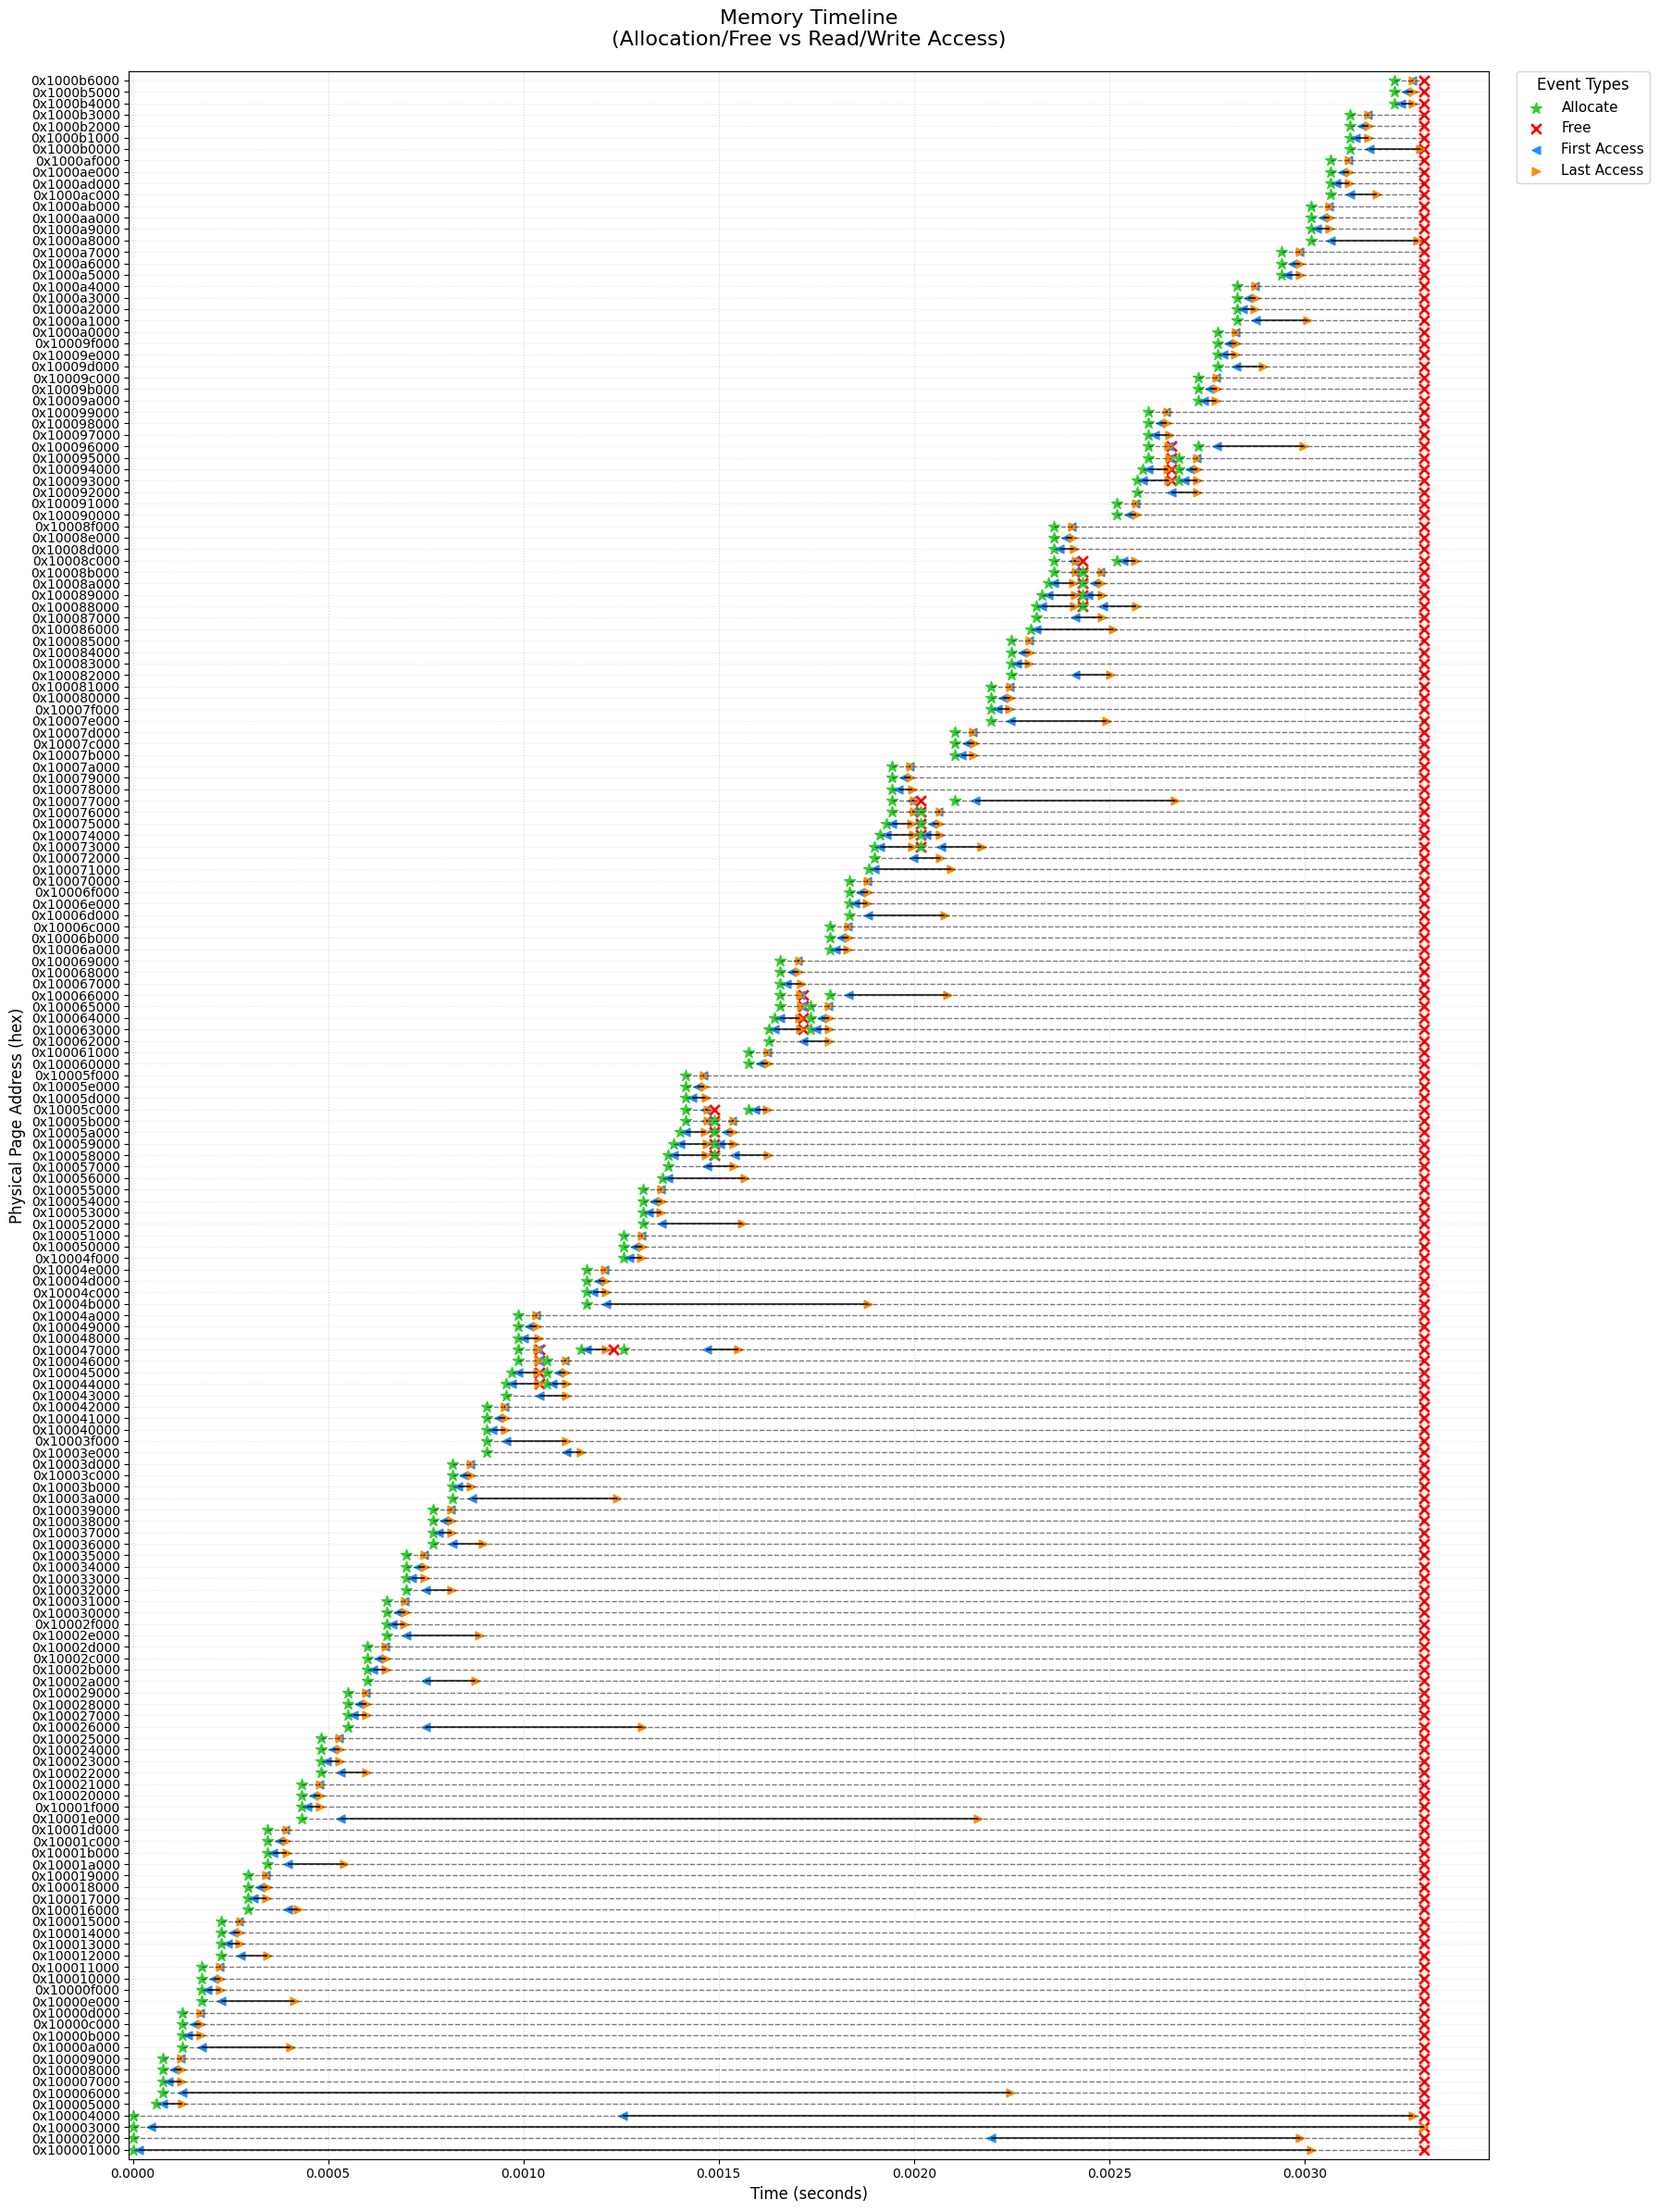

In [98]:
import matplotlib.pyplot as plt
import os

plt.figure(figsize=(18, 24))

# 创建统一的 y 轴映射
all_pages = sorted(lifecycle_df['PageID'].unique())
y_pos_map = {page: i for i, page in enumerate(all_pages)}

# 绘制每段生命周期
for i, row in lifecycle_df.iterrows():
    page = row['PageID']
    y_pos = y_pos_map[page]

    # 分配时间
    plt.scatter(row['AllocateTime'], y_pos,
                color='limegreen', marker='*', s=80,
                label='Allocate' if i == 0 else '')

    # 释放时间
    plt.scatter(row['FreeTime'], y_pos,
                color='red', marker='x', s=60, linewidth=2,
                label='Free' if i == 0 else '')

    # 生命周期虚线
    plt.hlines(y=y_pos,
               xmin=row['AllocateTime'],
               xmax=row['FreeTime'],
               colors='black', linestyles='dashed', alpha=0.5, linewidth=1)

    # 首次访问
    if pd.notnull(row['FirstAccessTime']):
        plt.scatter(row['FirstAccessTime'], y_pos,
                    color='dodgerblue', marker='<', s=40,
                    label='First Access' if i == 0 else '')

    # 最后访问
    if pd.notnull(row['LastAccessTime']):
        plt.scatter(row['LastAccessTime'], y_pos,
                    color='darkorange', marker='>', s=40,
                    label='Last Access' if i == 0 else '')

    # 读写访问时间线
    if pd.notnull(row['FirstAccessTime']) and pd.notnull(row['LastAccessTime']):
        plt.hlines(y=y_pos,
                   xmin=row['FirstAccessTime'],
                   xmax=row['LastAccessTime'],
                   colors='black', alpha=0.7, linewidth=1.5)

# 设置坐标轴标签
plt.yticks(range(len(all_pages)),
           [hex(page * page_size_byte) for page in all_pages],
           fontsize=10)  # 页物理地址
plt.xticks(fontsize=10)
plt.xlabel('Time (seconds)', fontsize=12)
plt.ylabel('Physical Page Address (hex)', fontsize=12)
plt.title('Memory Timeline\n(Allocation/Free vs Read/Write Access)', fontsize=16, pad=20)

# 计算时间范围
min_time = min(lifecycle_df['AllocateTime'].min(), lifecycle_df['FirstAccessTime'].min(skipna=True))
max_time = max(lifecycle_df['FreeTime'].max(), lifecycle_df['LastAccessTime'].max(skipna=True))
plt.xlim(left=min_time - 0.00001, right=max_time * 1.05)
plt.ylim(bottom=-0.8, top=len(all_pages) - 0.2)

# 添加网格线
plt.grid(True, axis='x', linestyle=':', alpha=0.5)
plt.grid(True, axis='y', linestyle=':', alpha=0.3)

# 图例右侧展示
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(),
           bbox_to_anchor=(1.02, 1),
           loc='upper left',
           borderaxespad=0.,
           frameon=True,
           fontsize=11,
           title='Event Types',
           title_fontsize=12)

# 调整布局
plt.subplots_adjust(right=0.85)
plt.tight_layout()

# 保存图像（可指定路径）
results_dir = "./results"
os.makedirs(results_dir, exist_ok=True)
timeline_path = os.path.join(results_dir, 'page_lifecycle_timeline.png')
plt.savefig(timeline_path, dpi=300, bbox_inches='tight')
plt.show()


#### 3. 内存占用

##### 3.1 计算内存占用

In [99]:
from collections import defaultdict

def compute_occupancy_and_metrics(events, page_size_byte):
    # 将同一时间点的 delta 合并
    delta_dict = defaultdict(int)
    for time, delta in events:
        delta_dict[time] += delta

    # 按时间排序
    sorted_times = sorted(delta_dict.keys())

    times = []
    usages = []
    current_usage = 0

    for t in sorted_times:
        times.append(t)
        current_usage += delta_dict[t]
        usages.append(current_usage)

    # 最大占用
    max_usage_pages = max(usages)
    max_usage_bytes = max_usage_pages * page_size_byte

    # 累积占用：注意 usages[i] 表示在 times[i] 到 times[i+1] 之间的高度
    total_usage_pages = 0
    for i in range(len(times) - 1):
        duration = times[i + 1] - times[i]
        height = usages[i]
        total_usage_pages += height * duration

    total_usage_bytes = total_usage_pages * page_size_byte

    return times, usages, max_usage_pages, max_usage_bytes, total_usage_pages, total_usage_bytes

# 分配-释放轨迹
alloc_times, alloc_usage, alloc_max_p, alloc_max_b, alloc_total_p, alloc_total_b = compute_occupancy_and_metrics(alloc_events, page_size_byte)

# 访问轨迹
access_times, access_usage, access_max_p, access_max_b, access_total_p, access_total_b = compute_occupancy_and_metrics(access_events, page_size_byte)

# 打印结果（带单位）
def format_bytes(size_bytes):
    if size_bytes >= 1024**2:
        return f"{size_bytes / 1024**2:.2f} MB"
    elif size_bytes >= 1024:
        return f"{size_bytes / 1024:.2f} KB"
    else:
        return f"{size_bytes:.2f} B"

# 比例计算
max_ratio = access_max_p / alloc_max_p if alloc_max_p > 0 else 0
total_ratio = access_total_p / alloc_total_p if alloc_total_p > 0 else 0

# 输出结果
print("///分配-释放///")
print(f"最大占用：{alloc_max_p} 页 ({format_bytes(alloc_max_b)})")
print(f"累积占用：{alloc_total_p:.6f} 页×秒 ({format_bytes(alloc_total_b)}·s)")

print("\n///首次访问-最后访问///")
print(f"最大占用：{access_max_p} 页 ({format_bytes(access_max_b)})")
print(f"累积占用：{access_total_p:.6f} 页×秒 ({format_bytes(access_total_b)}·s)")

print("\n///占用比///")
print(f"最大占用比（访问/分配）：{max_ratio:.2%}")
print(f"累积占用比（访问/分配）：{total_ratio:.2%}")

///分配-释放///
最大占用：182 页 (728.00 KB)
累积占用：0.328737 页×秒 (1.31 KB·s)

///首次访问-最后访问///
最大占用：14 页 (56.00 KB)
累积占用：0.022988 页×秒 (94.16 B·s)

///占用比///
最大占用比（访问/分配）：7.69%
累积占用比（访问/分配）：6.99%


##### 3.2 绘制内存占用时间线图

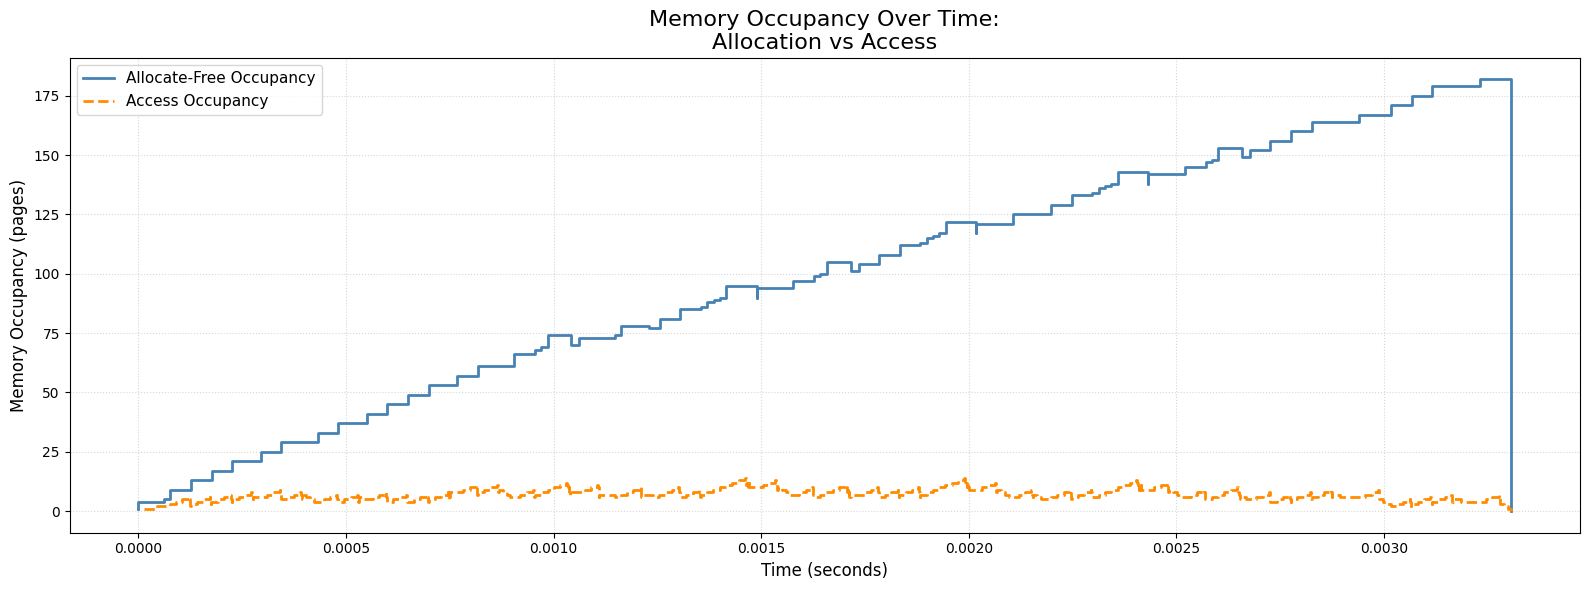

In [100]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

# 构建“Allocate - Free”事件列表
alloc_events = []
for _, row in lifecycle_df.iterrows():
    alloc_events.append((row['AllocateTime'], 1))   # 分配 +1
    alloc_events.append((row['FreeTime'], -1))      # 释放 -1
alloc_events.sort()

# 构建“FirstAccess - LastAccess”事件列表
access_events = []
for _, row in lifecycle_df.iterrows():
    access_events.append((row['FirstAccessTime'], 1))   # 首次访问 +1
    access_events.append((row['LastAccessTime'], -1))   # 最后访问 -1
access_events.sort()

# 生成时间和占用曲线
def compute_occupancy(events):
    times = []
    usages = []
    current = 0
    for time, delta in events:
        times.append(time)
        current += delta
        usages.append(current)
    return times, usages

alloc_times, alloc_usage = compute_occupancy(alloc_events)
access_times, access_usage = compute_occupancy(access_events)

# 绘图
plt.figure(figsize=(16, 6))
plt.step(alloc_times, alloc_usage, where='post', label='Allocate-Free Occupancy', color='steelblue', linewidth=2)
plt.step(access_times, access_usage, where='post', label='Access Occupancy', color='darkorange', linewidth=2, linestyle='--')

# 图表设置
plt.xlabel('Time (seconds)', fontsize=12)
plt.ylabel('Memory Occupancy (pages)', fontsize=12)
plt.title('Memory Occupancy Over Time:\nAllocation vs Access', fontsize=16)
plt.grid(True, linestyle=':', alpha=0.5)
plt.legend(fontsize=11)

# 保存或展示
occupancy_compare_path = os.path.join(results_dir, 'memory_occupancy_compare.png')
plt.savefig(occupancy_compare_path, dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

#### 4. 内存访问

##### 4.1 处理内存访问数据

In [101]:
# 按 PageID 分组，计算各页面的关键时间指标
rw_df = page_access_df[page_access_df['AccessType'].isin(['*mem.ReadReq', '*mem.WriteReq'])]
print(rw_df)

page_rw_stats_df = rw_df.groupby('PageID').agg({
    'StartTime': ['min'],
    "EndTime": ['max'],
    'AccessType': lambda x: list(x.unique())  # 记录所有操作类型
}).reset_index()
page_rw_stats_df.columns = ['PageID', 'FirstAccessTime', 'LastAccessTime', 'AccessTypes']

# 添加生命周期持续时间列
page_rw_stats_df['ActualLifeDuration'] = page_rw_stats_df['LastAccessTime'] - page_rw_stats_df['FirstAccessTime']

print(page_rw_stats_df)

      DeviceID   PageID     AccessType  StartTime   EndTime
1            0  1048577  *mem.WriteReq   0.000015  0.000015
2            0  1048577  *mem.WriteReq   0.000030  0.000030
3            0  1048577   *mem.ReadReq   0.000226  0.000226
4            0  1048577   *mem.ReadReq   0.000285  0.000285
5            0  1048577   *mem.ReadReq   0.002913  0.002913
...        ...      ...            ...        ...       ...
1366         0  1048757  *mem.WriteReq   0.003261  0.003261
1367         0  1048757  *mem.WriteReq   0.003261  0.003261
1368         0  1048757   *mem.ReadReq   0.003278  0.003278
1370         0  1048758  *mem.WriteReq   0.003276  0.003276
1371         0  1048758   *mem.ReadReq   0.003278  0.003278

[1134 rows x 5 columns]
      PageID  FirstAccessTime  LastAccessTime                    AccessTypes  \
0    1048577         0.000015        0.003017  [*mem.WriteReq, *mem.ReadReq]   
1    1048578         0.002198        0.002988  [*mem.WriteReq, *mem.ReadReq]   
2    1048579   

##### 4.2 绘制内存访问图

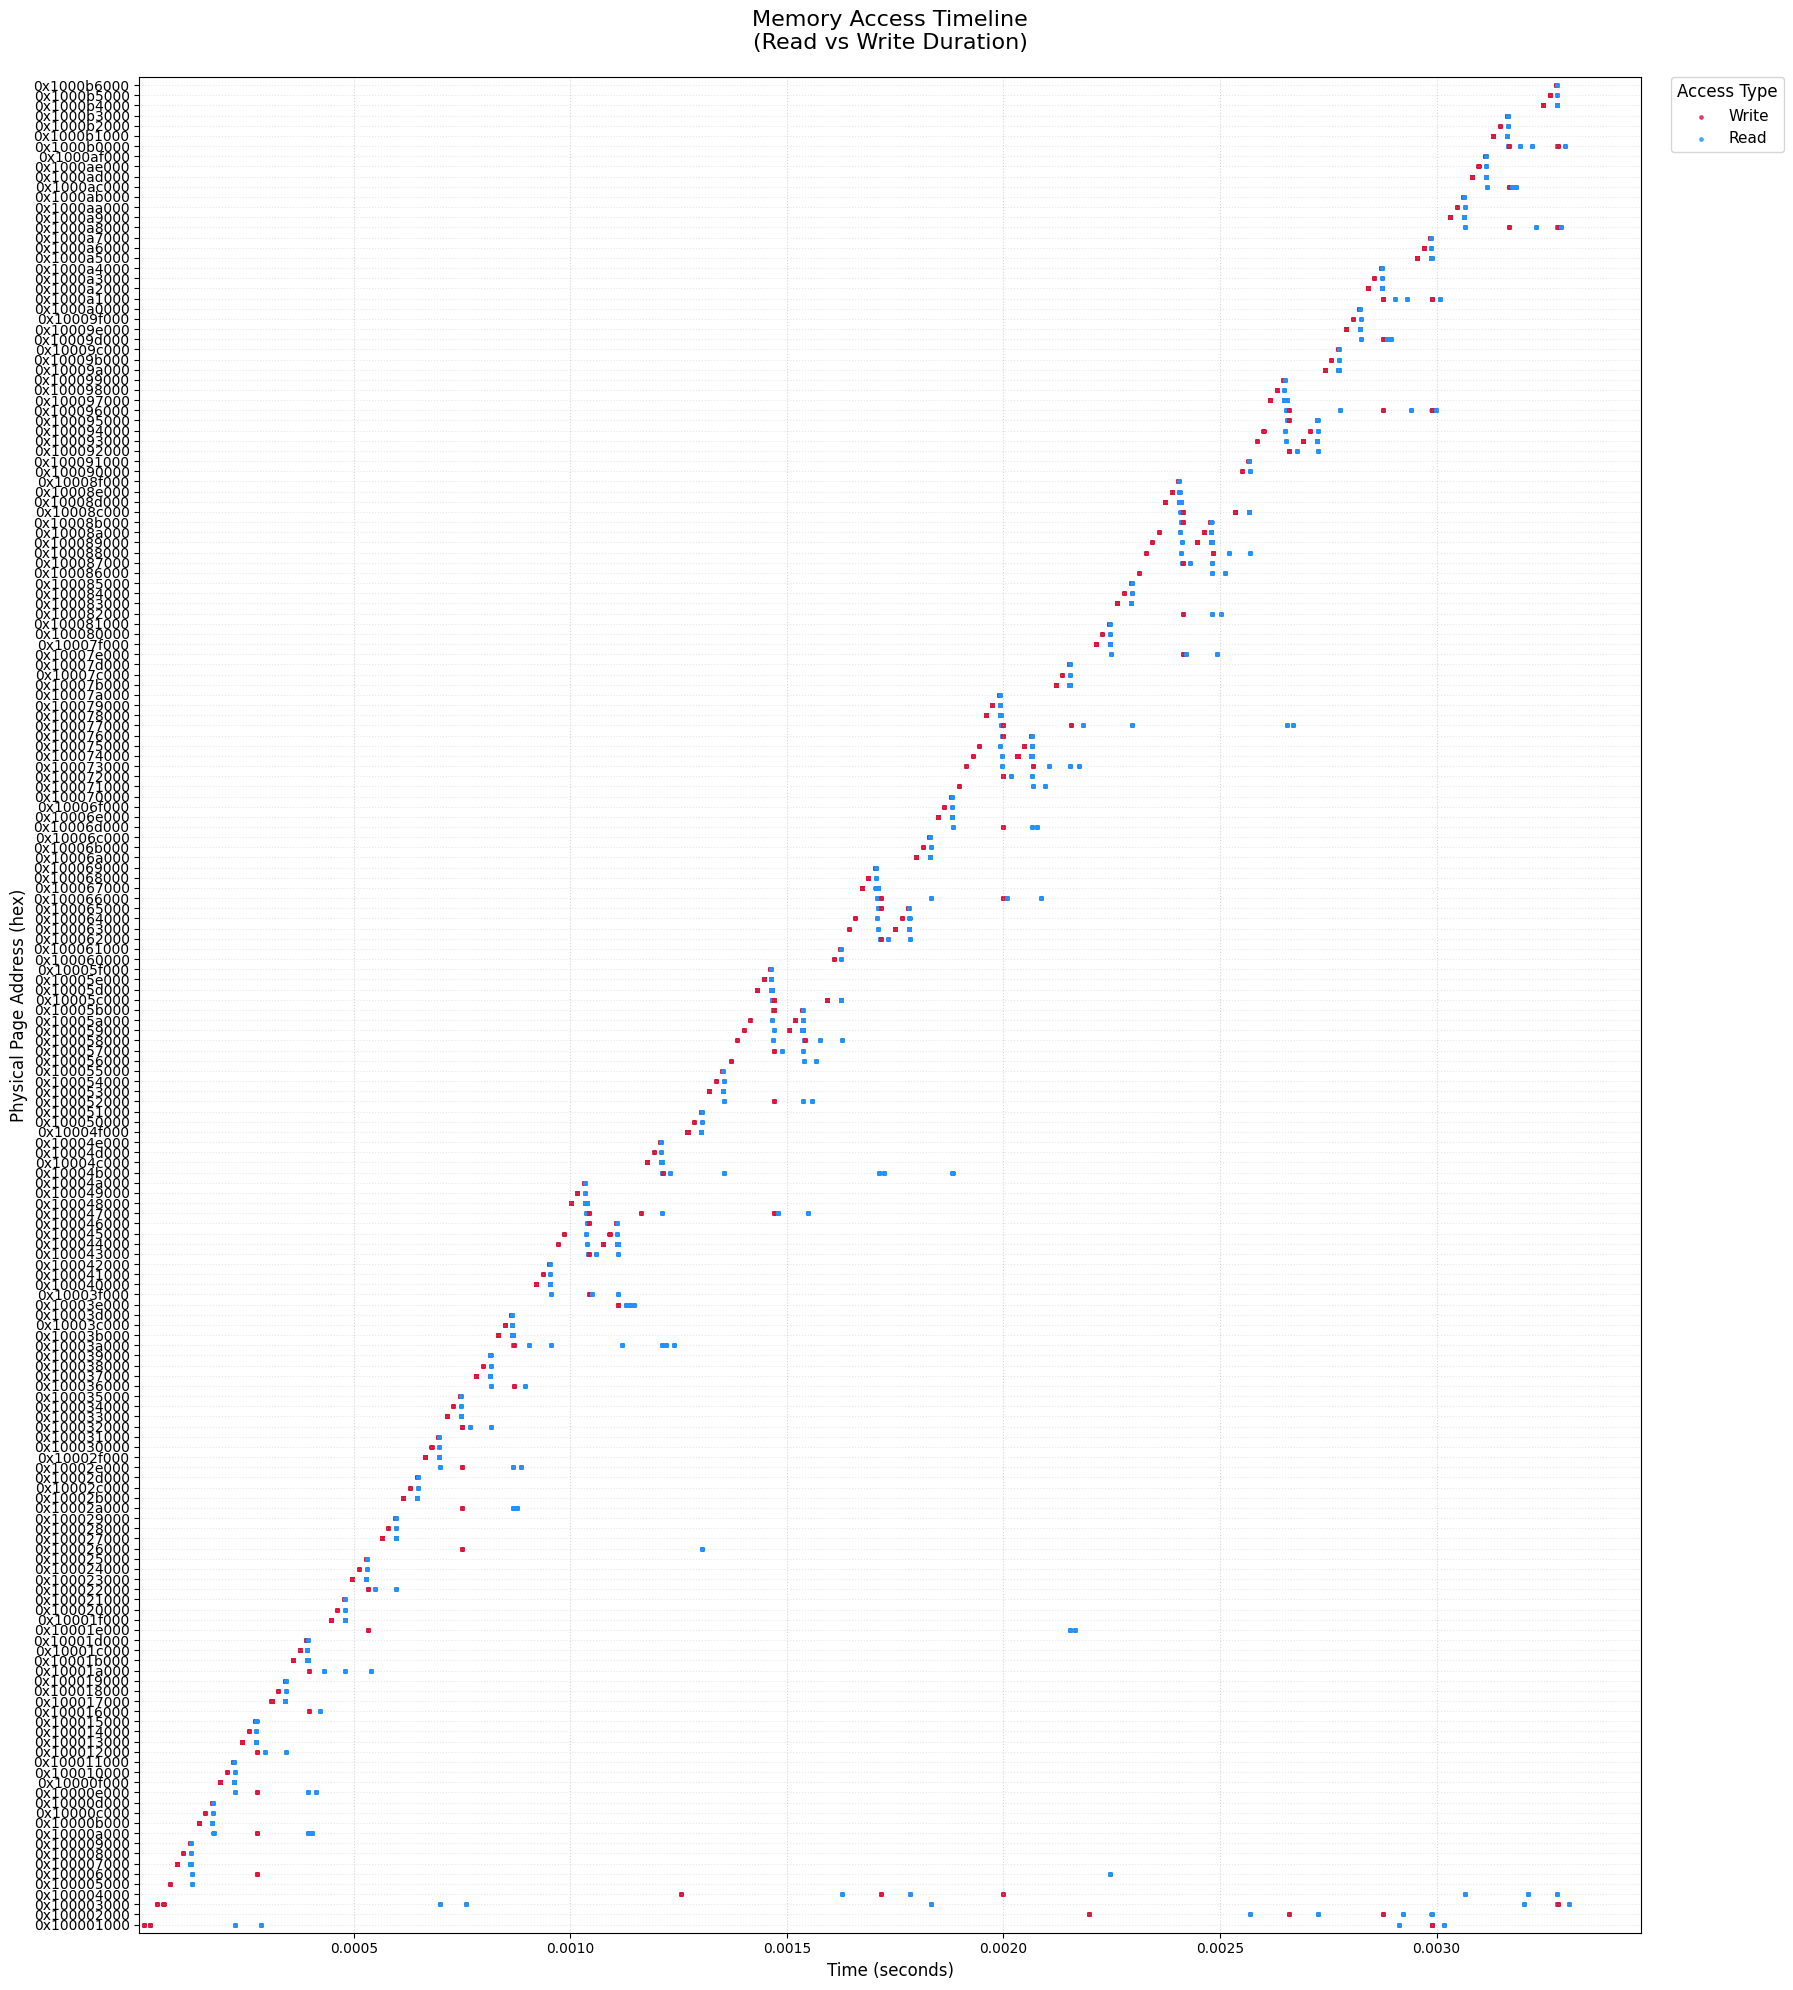

In [102]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 20))

# 创建统一的 y 轴映射（仅基于 rw_df 的 PageID）
all_pages = sorted(rw_df['PageID'].unique())
y_pos_map = {page: i for i, page in enumerate(all_pages)}

# 绘制每个读写访问的持续时间（横线）
for _, row in rw_df.iterrows():
    y_pos = y_pos_map[row['PageID']]
    
    # 根据访问类型选择颜色和样式
    if row['AccessType'] == '*mem.ReadReq':
        color = 'dodgerblue'
        linestyle = '-'  # 实线表示读
        label = 'Read' if _ == 0 or 'Read' not in plt.gca().get_legend_handles_labels()[1] else ''
    else:  # '*mem.WriteReq'
        color = 'crimson'
        linestyle = '--'  # 虚线表示写
        label = 'Write' if _ == 0 or 'Write' not in plt.gca().get_legend_handles_labels()[1] else ''
    
    # 生成在 StartTime 到 EndTime 之间的横向点
    x_points = np.linspace(row['StartTime'], row['EndTime'], num=20)
    y_points = np.full_like(x_points, y_pos)
    
    plt.scatter(
        x_points,
        y_points,
        color=color,
        s=6,           # 控制点的大小
        alpha=0.7,
        label=label
    )

    # 绘制横线（连接 StartTime 和 EndTime）
    # plt.hlines(
    #     y=y_pos,
    #     xmin=row['StartTime'],
    #     xmax=row['EndTime'],
    #     colors=color,
    #     linestyles=linestyle,
    #     alpha=0.7,
    #     linewidth=15,
    #     label=label
    # )
    
    # 可选：在访问的起点和终点添加标记
    # plt.scatter(
    #     row['StartTime'], y_pos,
    #     color=color,
    #     marker='>',  # 右箭头表示开始
    #     s=50,
    #     alpha=0.9,
    #     label=''  # 不重复添加图例
    # )
    # plt.scatter(
    #     row['EndTime'], y_pos,
    #     color=color,
    #     marker='<',  # 左箭头表示结束
    #     s=50,
    #     alpha=0.9,
    #     label=''
    # )

# 设置坐标轴
# plt.yticks(range(len(all_pages)), all_pages, fontsize=10) # y轴显示page id
plt.yticks(range(len(all_pages)), [hex(page * page_size_byte) for page in all_pages], fontsize=10) # y轴显示页物理地址
plt.xticks(fontsize=10)
plt.xlabel('Time (seconds)', fontsize=12)
# plt.ylabel('Page ID', fontsize=12) # y轴显示page id
plt.ylabel('Physical Page Address (hex)', fontsize=12) # y轴显示页物理地址
plt.title('Memory Access Timeline\n(Read vs Write Duration)', fontsize=16, pad=20)

# 调整坐标轴范围
min_time = rw_df['StartTime'].min()
max_time = rw_df['EndTime'].max()
plt.xlim(left=min_time - 0.00001, right=max_time * 1.05)
plt.ylim(bottom=-0.8, top=len(all_pages) - 0.2)

# 添加网格线
plt.grid(True, axis='x', linestyle=':', alpha=0.5)
plt.grid(True, axis='y', linestyle=':', alpha=0.3)

# 自定义图例（避免重复）
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))  # 去重
plt.legend(
    unique_labels.values(),
    unique_labels.keys(),
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    borderaxespad=0.,
    frameon=True,
    fontsize=11,
    title='Access Type',
    title_fontsize=12
)

# 调整布局
plt.subplots_adjust(right=0.85)
plt.tight_layout()

memory_access_path = os.path.join(results_dir, 'memory_access.png')
plt.savefig(memory_access_path, dpi=300, bbox_inches='tight')
plt.show()